# Activity 3: Student Segmentation via Machine Learning

## Objective
Use K-Means clustering to identify hidden patterns and segment students into meaningful groups (e.g., At-Risk, High Performers, Career Confused).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set style
sns.set(style="whitegrid")

## 1. Load Data

In [2]:
try:
    df = pd.read_csv('../Data/students_with_scores_v2.csv')
    print("Loaded from ../Data/")
except FileNotFoundError:
    df = pd.read_csv('students_with_scores_v2.csv')
    print("Loaded from local directory")

print(f"Records: {len(df)}")
df.head()

Loaded from ../Data/
Records: 615


,student_id,age,program,semester,gpa,attendance,assignments_completion,stress_level,sleep_hours,mental_wellbeing,...,distractions,career_clarity,skill_readiness,engagement_score,APS,WWS,PTMS,CRS,SRI,Risk_Category
0,S001,20,B.Tech,4,6.82,73.8,71.6,5,7.2,3,...,3,6,5.059832,75.8,70.0,54.0,66.2,55.3,61.6,Blue
1,S002,24,MBA,5,9.68,96.2,100.0,5,6.7,4,...,1,10,8.071779,81.4,97.3,56.1,83.3,90.4,82.5,Green
2,S003,18,BCA,1,7.98,85.2,80.3,6,6.1,6,...,5,6,8.448132,85.8,81.0,58.9,62.2,72.2,69.5,Blue
3,S004,24,MBA,5,9.80,93.2,100.0,4,7.7,8,...,5,8,8.633248,87.1,97.4,78.9,67.4,83.2,83.2,Green
4,S005,22,B.Tech,8,7.47,70.9,65.4,4,6.7,6,...,5,6,6.055871,74.6,72.1,67.1,44.9,60.3,62.5,Blue


## 2. Preprocessing
We select behavioral and raw performance features for clustering. We avoid using the derived scores (SRI, APS) directly to see if the raw data clusters naturally.

In [3]:
features = ['gpa', 'attendance', 'stress_level', 'mental_wellbeing', 
            'productivity_score', 'career_clarity', 'engagement_score']

X = df[features]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3. Determine Optimal K (Elbow Method)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

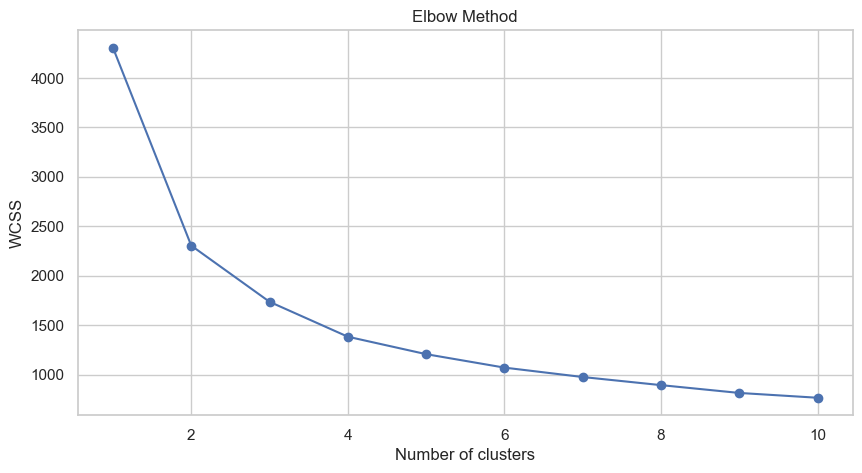

In [4]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## 4. K-Means Clustering
Based on the elbow plot and our domain knowledge (expecting groups like High, Avg, At-Risk, Confused), we select **K=4**.

In [5]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## 5. Cluster Analysis

In [6]:
# Mean values per cluster
cluster_means = df.groupby('Cluster')[features].mean().round(2)
cluster_means

,gpa,attendance,stress_level,mental_wellbeing,productivity_score,career_clarity,engagement_score
Cluster,,,,,,,
0,5.98,67.14,7.76,2.47,3.49,4.50,63.72
1,7.36,80.23,5.54,4.94,6.38,5.73,79.22
2,9.16,94.73,3.61,6.46,8.45,9.10,91.47
3,1.85,27.42,9.03,1.62,3.16,2.19,25.77


### Interpretation
We can map these clusters to archetypes:
- **Cluster 0**: Likely High Achievers (High GPA/Attendance)
- **Cluster 1**: Likely At-Risk/Burnout (High Stress)
- **Cluster 2**: Likely Drifters (High GPA, Low Career Clarity)
- **Cluster 3**: Likely Grinders (Low GPA, High Engagement/Attendance)

## 6. Visualization (PCA)

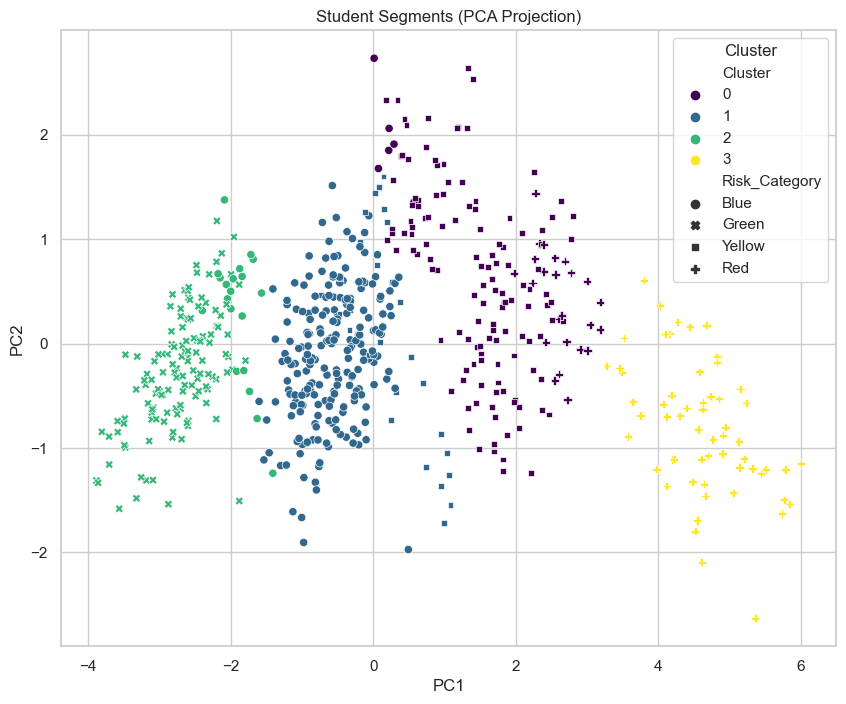

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', style=df['Risk_Category'])
plt.title('Student Segments (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

## 7. Cluster vs Rule-Based Risk Comparison

In [8]:
pd.crosstab(df['Cluster'], df['Risk_Category'])

Risk_Category,Blue,Green,Red,Yellow
Cluster,,,,
0,6,0,24,130
1,214,0,0,28
2,20,135,0,0
3,0,0,58,0
